**Maps of World Power Consumption in 2014** (Charles Umesi, 13 July 2023)

For maps, we will require *Plotly*; two types of maps will be generated: *choropleth maps* and *density maps*. First, choropleth maps; relevant Plotly modules are imported

In [1]:
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
# Also:
import chart_studio.plotly as py

We will also require our usual data science dynamic duo!

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Read csv file
df = pd.read_csv('2014_World_Power_Consumption')

In [4]:
df.head()

,Country,Power Consumption KWH,Text
0,China,5.523000e+12,"China 5,523,000,000,000"
1,United States,3.832000e+12,"United 3,832,000,000,000"
2,European,2.771000e+12,"European 2,771,000,000,000"
3,Russia,1.065000e+12,"Russia 1,065,000,000,000"
4,Japan,9.210000e+11,"Japan 921,000,000,000"


Two things: The first is that we notice the *United States* in the *Country* column is represented as *United* in the *Text* column. This is actually going to be a problem for Plotly as we want a map such that when we hover over a country, information about the country and its power usage are displayed, which is what *Text* allows us to do. But the country name in the *Text* column must match the country name in the *Country* column, which is not the case with the *United States*.

The second thing is that the country name in the *Country* column must be the *recognised* country name for Plotly otherwise again, the display on hover won't work.

For now, we will *assume* that all the names in the *Country* column are the recognised country names, so let us deal with just the *Text* column, but before that, let us do our routine check on the completeness and appropriateness of our data 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                219 non-null    object 
 1   Power Consumption KWH  219 non-null    float64
 2   Text                   219 non-null    object 
dtypes: float64(1), object(2)
memory usage: 5.3+ KB


Our data is complete and in the correct types; let us see how widespread discrepancies between *Country* and *Text* columns are

In [6]:
df['Text_split[0]'] = df['Text'].map(lambda x : x.split(' ')[0])

In [7]:
df.head()

,Country,Power Consumption KWH,Text,Text_split[0]
0,China,5.523000e+12,"China 5,523,000,000,000",China
1,United States,3.832000e+12,"United 3,832,000,000,000",United
2,European,2.771000e+12,"European 2,771,000,000,000",European
3,Russia,1.065000e+12,"Russia 1,065,000,000,000",Russia
4,Japan,9.210000e+11,"Japan 921,000,000,000",Japan


In [8]:
ambigious = np.setdiff1d(list(df['Text_split[0]']),list(df['Country']),assume_unique=False)
ambigious

array(['United'], dtype='<U13')

The above test reveals that the discrepancies between *Country* and *Text* (or the newly created *Text_split[0]*) columns are limited to *United* rows. Let us see how many rows are affected

In [9]:
df[df['Text_split[0]'] == 'United']

,Country,Power Consumption KWH,Text,Text_split[0]
1,United States,3.832000e+12,"United 3,832,000,000,000",United
11,United Kingdom,3.191000e+11,"United 319,100,000,000",United
33,United Arab Emirates,9.328000e+10,"United 93,280,000,000",United


So, based on the *assumption* that all the country names in the *Country* column are recognised country names, the problem *appears* to be limited to 3 rows; we shall now correct these

In [10]:
def united(col):
    Country = col[0]
    Text_split = col[1]
    
    if Text_split == 'United':
        return Country
    else:
        return Text_split

In [11]:
df['Text_split[0]'] = df[['Country','Text_split[0]']].apply(united,axis=1) 

In [12]:
df[df['Text_split[0]'].str.contains('United') == True]

,Country,Power Consumption KWH,Text,Text_split[0]
1,United States,3.832000e+12,"United 3,832,000,000,000",United States
11,United Kingdom,3.191000e+11,"United 319,100,000,000",United Kingdom
33,United Arab Emirates,9.328000e+10,"United 93,280,000,000",United Arab Emirates


We can now correct the relevant rows in our *Text* column

In [13]:
def text(col):
    First = col[0]
    Second = col[1]
    
    First_split = First.split(' ')
    if First_split[0] != Second:
        First_split[0] = Second
        return ' '.join(First_split)
    else:
        return ' '.join(First_split)

In [14]:
df['Text'] = df[['Text','Text_split[0]']].apply(text,axis=1)

In [15]:
df[df['Text_split[0]'].str.contains('United') == True]

,Country,Power Consumption KWH,Text,Text_split[0]
1,United States,3.832000e+12,"United States 3,832,000,000,000",United States
11,United Kingdom,3.191000e+11,"United Kingdom 319,100,000,000",United Kingdom
33,United Arab Emirates,9.328000e+10,"United Arab Emirates 93,280,000,000",United Arab Emirates


Okay, let us now generate our choropleth map and see if our assumptions are correct

In [16]:
data = dict(type = 'choropleth',
            locations = df['Text'],
            locationmode = "country names" ,
            marker = dict(line = dict(color = 'rgb(0,0,0)',width=1)),
            colorscale = 'ylorrd',
            z = df['Power Consumption KWH'],
            text = df['Country'],
            colorbar = {'title':'2014 Power Consumption'}
           )
layout = dict(title = '2014 Power Consumption',
             geo = dict(scope='world',showframe=False,
                        projection = {'type':'mercator'})
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

You may not be able to see the iplot version in cell 16 as it is an interactive version, so a static png version is shown below

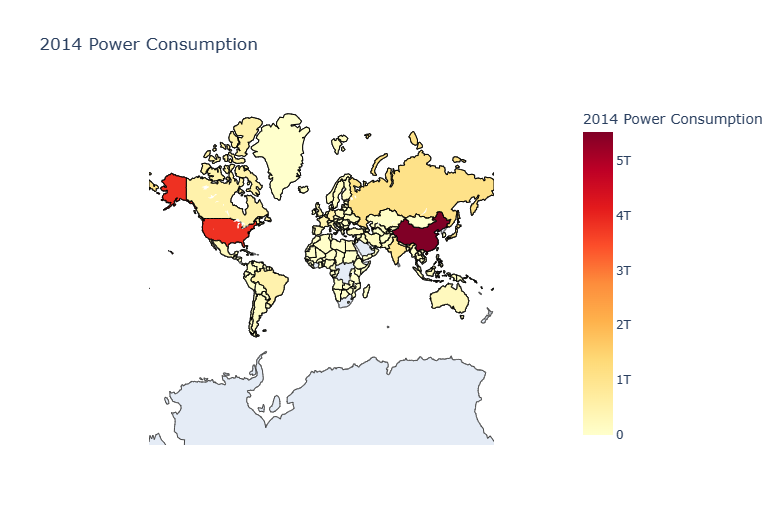

Even without zooming in on our map or rendering a larger map, we can already see noticeable areas of grey representing countries that were not picked up by Plotly including Saudi Arabia, the two Congos, South Africa. These are the obvious ones but there may be less obvious ones. Problem rows in the data may be a lot more widespread than was previously thought.

As we're dealing with 219 countries and territories, we would have to do our investigation and corrections programmatically. The first thing is to see if all country names in the *Country* column are recorded in the dataset as *recognised* country names. This is potentially complicated to do but let's start simple

In [17]:
df[(df['Text_split[0]'].str.contains('Saudi')==True) | (df['Text_split[0]'].str.contains('South')==True) | (df['Text_split[0]'].str.contains('Congo')==True)]

,Country,Power Consumption KWH,Text,Text_split[0]
16,Saudi,2.316000e+11,"Saudi 231,600,000,000",Saudi
18,South,2.116000e+11,"South 211,600,000,000",South
101,"Congo,",7.292000e+09,"Congo, 7,292,000,000","Congo,"
160,"Congo,",7.400000e+08,"Congo, 740,000,000","Congo,"
163,South,6.941000e+08,"South 694,100,000",South


We can see that neither Saudi Arabia nor either of the two Congos nor South Africa have been recorded in their recognised names. Moreover, with multiple entries for 'South' and 'Congo' we need to decide which Congo is which and which South belongs to South Africa and so on (more on that later).

Right, our next step is to retrieve the list of recognised country names. This list is actually in *JSON* format and can be *scrapped* from its website. We will require a couple of libraries for that

In [18]:
import requests
from bs4 import BeautifulSoup

In [19]:
URL = "http://country.io/names.json"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")

In [20]:
soup

{"BD": "Bangladesh", "BE": "Belgium", "BF": "Burkina Faso", "BG": "Bulgaria", "BA": "Bosnia and Herzegovina", "BB": "Barbados", "WF": "Wallis and Futuna", "BL": "Saint Barthelemy", "BM": "Bermuda", "BN": "Brunei", "BO": "Bolivia", "BH": "Bahrain", "BI": "Burundi", "BJ": "Benin", "BT": "Bhutan", "JM": "Jamaica", "BV": "Bouvet Island", "BW": "Botswana", "WS": "Samoa", "BQ": "Bonaire, Saint Eustatius and Saba ", "BR": "Brazil", "BS": "Bahamas", "JE": "Jersey", "BY": "Belarus", "BZ": "Belize", "RU": "Russia", "RW": "Rwanda", "RS": "Serbia", "TL": "East Timor", "RE": "Reunion", "TM": "Turkmenistan", "TJ": "Tajikistan", "RO": "Romania", "TK": "Tokelau", "GW": "Guinea-Bissau", "GU": "Guam", "GT": "Guatemala", "GS": "South Georgia and the South Sandwich Islands", "GR": "Greece", "GQ": "Equatorial Guinea", "GP": "Guadeloupe", "JP": "Japan", "GY": "Guyana", "GG": "Guernsey", "GF": "French Guiana", "GE": "Georgia", "GD": "Grenada", "GB": "United Kingdom", "GA": "Gabon", "SV": "El Salvador", "GN":

So, we now have a full 'list' of all the recognised country names that Plotly uses; this list looks like a dictionary, but it is **not** a dictionary. As alluded to earlier, on the website, it is a *JSON* data structure and although it is closely associated with JavaScript, it is not exclusive to JavaScript. That said, Python cannot read JSON directly without an appropriate library, but now that we have scrapped the JSON off a website, what type of data structure are we looking at now (is it still *JSON*)?

In [21]:
type(soup)

bs4.BeautifulSoup

So, *soup* is a Beautiful Soup object; this essentially means that we will require Beautiful Soup in order to extract information off the list of countries. Let us find out its length

In [22]:
len(soup)

1

This is bad news because it suggests the entire list is within one HTML tag; this makes perfect sense for a JSON but in terms of extracting the country names off the *soup* variable, this is a bit of a nightmare. Let us verify that the entire list of names are within one HTML tag

In [23]:
soup2 = BeautifulSoup(page.text,"lxml")
soup2

<html><body><p>{"BD": "Bangladesh", "BE": "Belgium", "BF": "Burkina Faso", "BG": "Bulgaria", "BA": "Bosnia and Herzegovina", "BB": "Barbados", "WF": "Wallis and Futuna", "BL": "Saint Barthelemy", "BM": "Bermuda", "BN": "Brunei", "BO": "Bolivia", "BH": "Bahrain", "BI": "Burundi", "BJ": "Benin", "BT": "Bhutan", "JM": "Jamaica", "BV": "Bouvet Island", "BW": "Botswana", "WS": "Samoa", "BQ": "Bonaire, Saint Eustatius and Saba ", "BR": "Brazil", "BS": "Bahamas", "JE": "Jersey", "BY": "Belarus", "BZ": "Belize", "RU": "Russia", "RW": "Rwanda", "RS": "Serbia", "TL": "East Timor", "RE": "Reunion", "TM": "Turkmenistan", "TJ": "Tajikistan", "RO": "Romania", "TK": "Tokelau", "GW": "Guinea-Bissau", "GU": "Guam", "GT": "Guatemala", "GS": "South Georgia and the South Sandwich Islands", "GR": "Greece", "GQ": "Equatorial Guinea", "GP": "Guadeloupe", "JP": "Japan", "GY": "Guyana", "GG": "Guernsey", "GF": "French Guiana", "GE": "Georgia", "GD": "Grenada", "GB": "United Kingdom", "GA": "Gabon", "SV": "El S

They are indeed all within one HTML tag, &lt;p&gt;&lt;/p&gt;; so, we'll call on Beautiful Soup's string method to convert the entire list to one string, and then use the various string methods to break the list down country by country, which we can then use to correct the *Country* column in our dataset. Note that this involves several steps

In [24]:
j = soup.string.replace('{','')
j = j.replace('}','')
j

'"BD": "Bangladesh", "BE": "Belgium", "BF": "Burkina Faso", "BG": "Bulgaria", "BA": "Bosnia and Herzegovina", "BB": "Barbados", "WF": "Wallis and Futuna", "BL": "Saint Barthelemy", "BM": "Bermuda", "BN": "Brunei", "BO": "Bolivia", "BH": "Bahrain", "BI": "Burundi", "BJ": "Benin", "BT": "Bhutan", "JM": "Jamaica", "BV": "Bouvet Island", "BW": "Botswana", "WS": "Samoa", "BQ": "Bonaire, Saint Eustatius and Saba ", "BR": "Brazil", "BS": "Bahamas", "JE": "Jersey", "BY": "Belarus", "BZ": "Belize", "RU": "Russia", "RW": "Rwanda", "RS": "Serbia", "TL": "East Timor", "RE": "Reunion", "TM": "Turkmenistan", "TJ": "Tajikistan", "RO": "Romania", "TK": "Tokelau", "GW": "Guinea-Bissau", "GU": "Guam", "GT": "Guatemala", "GS": "South Georgia and the South Sandwich Islands", "GR": "Greece", "GQ": "Equatorial Guinea", "GP": "Guadeloupe", "JP": "Japan", "GY": "Guyana", "GG": "Guernsey", "GF": "French Guiana", "GE": "Georgia", "GD": "Grenada", "GB": "United Kingdom", "GA": "Gabon", "SV": "El Salvador", "GN":

In [25]:
j = j.replace('"','')
j = j.replace('"','')
j

'BD: Bangladesh, BE: Belgium, BF: Burkina Faso, BG: Bulgaria, BA: Bosnia and Herzegovina, BB: Barbados, WF: Wallis and Futuna, BL: Saint Barthelemy, BM: Bermuda, BN: Brunei, BO: Bolivia, BH: Bahrain, BI: Burundi, BJ: Benin, BT: Bhutan, JM: Jamaica, BV: Bouvet Island, BW: Botswana, WS: Samoa, BQ: Bonaire, Saint Eustatius and Saba , BR: Brazil, BS: Bahamas, JE: Jersey, BY: Belarus, BZ: Belize, RU: Russia, RW: Rwanda, RS: Serbia, TL: East Timor, RE: Reunion, TM: Turkmenistan, TJ: Tajikistan, RO: Romania, TK: Tokelau, GW: Guinea-Bissau, GU: Guam, GT: Guatemala, GS: South Georgia and the South Sandwich Islands, GR: Greece, GQ: Equatorial Guinea, GP: Guadeloupe, JP: Japan, GY: Guyana, GG: Guernsey, GF: French Guiana, GE: Georgia, GD: Grenada, GB: United Kingdom, GA: Gabon, SV: El Salvador, GN: Guinea, GM: Gambia, GL: Greenland, GI: Gibraltar, GH: Ghana, OM: Oman, TN: Tunisia, JO: Jordan, HR: Croatia, HT: Haiti, HU: Hungary, HK: Hong Kong, HN: Honduras, HM: Heard Island and McDonald Islands, 

In [26]:
k = j.split(',')
k

['BD: Bangladesh',
 ' BE: Belgium',
 ' BF: Burkina Faso',
 ' BG: Bulgaria',
 ' BA: Bosnia and Herzegovina',
 ' BB: Barbados',
 ' WF: Wallis and Futuna',
 ' BL: Saint Barthelemy',
 ' BM: Bermuda',
 ' BN: Brunei',
 ' BO: Bolivia',
 ' BH: Bahrain',
 ' BI: Burundi',
 ' BJ: Benin',
 ' BT: Bhutan',
 ' JM: Jamaica',
 ' BV: Bouvet Island',
 ' BW: Botswana',
 ' WS: Samoa',
 ' BQ: Bonaire',
 ' Saint Eustatius and Saba ',
 ' BR: Brazil',
 ' BS: Bahamas',
 ' JE: Jersey',
 ' BY: Belarus',
 ' BZ: Belize',
 ' RU: Russia',
 ' RW: Rwanda',
 ' RS: Serbia',
 ' TL: East Timor',
 ' RE: Reunion',
 ' TM: Turkmenistan',
 ' TJ: Tajikistan',
 ' RO: Romania',
 ' TK: Tokelau',
 ' GW: Guinea-Bissau',
 ' GU: Guam',
 ' GT: Guatemala',
 ' GS: South Georgia and the South Sandwich Islands',
 ' GR: Greece',
 ' GQ: Equatorial Guinea',
 ' GP: Guadeloupe',
 ' JP: Japan',
 ' GY: Guyana',
 ' GG: Guernsey',
 ' GF: French Guiana',
 ' GE: Georgia',
 ' GD: Grenada',
 ' GB: United Kingdom',
 ' GA: Gabon',
 ' SV: El Salvador',
 ' 

In [27]:
l = []
for i in k:
    l.append(i.split(':'))
l

[['BD', ' Bangladesh'],
 [' BE', ' Belgium'],
 [' BF', ' Burkina Faso'],
 [' BG', ' Bulgaria'],
 [' BA', ' Bosnia and Herzegovina'],
 [' BB', ' Barbados'],
 [' WF', ' Wallis and Futuna'],
 [' BL', ' Saint Barthelemy'],
 [' BM', ' Bermuda'],
 [' BN', ' Brunei'],
 [' BO', ' Bolivia'],
 [' BH', ' Bahrain'],
 [' BI', ' Burundi'],
 [' BJ', ' Benin'],
 [' BT', ' Bhutan'],
 [' JM', ' Jamaica'],
 [' BV', ' Bouvet Island'],
 [' BW', ' Botswana'],
 [' WS', ' Samoa'],
 [' BQ', ' Bonaire'],
 [' Saint Eustatius and Saba '],
 [' BR', ' Brazil'],
 [' BS', ' Bahamas'],
 [' JE', ' Jersey'],
 [' BY', ' Belarus'],
 [' BZ', ' Belize'],
 [' RU', ' Russia'],
 [' RW', ' Rwanda'],
 [' RS', ' Serbia'],
 [' TL', ' East Timor'],
 [' RE', ' Reunion'],
 [' TM', ' Turkmenistan'],
 [' TJ', ' Tajikistan'],
 [' RO', ' Romania'],
 [' TK', ' Tokelau'],
 [' GW', ' Guinea-Bissau'],
 [' GU', ' Guam'],
 [' GT', ' Guatemala'],
 [' GS', ' South Georgia and the South Sandwich Islands'],
 [' GR', ' Greece'],
 [' GQ', ' Equatori

In [28]:
# Discard the abbreviations
values = []
for i in l:
    if len(i) >= 2:
        values.append(i[1])
    else:
        values.append(i[0])

In [29]:
values

[' Bangladesh',
 ' Belgium',
 ' Burkina Faso',
 ' Bulgaria',
 ' Bosnia and Herzegovina',
 ' Barbados',
 ' Wallis and Futuna',
 ' Saint Barthelemy',
 ' Bermuda',
 ' Brunei',
 ' Bolivia',
 ' Bahrain',
 ' Burundi',
 ' Benin',
 ' Bhutan',
 ' Jamaica',
 ' Bouvet Island',
 ' Botswana',
 ' Samoa',
 ' Bonaire',
 ' Saint Eustatius and Saba ',
 ' Brazil',
 ' Bahamas',
 ' Jersey',
 ' Belarus',
 ' Belize',
 ' Russia',
 ' Rwanda',
 ' Serbia',
 ' East Timor',
 ' Reunion',
 ' Turkmenistan',
 ' Tajikistan',
 ' Romania',
 ' Tokelau',
 ' Guinea-Bissau',
 ' Guam',
 ' Guatemala',
 ' South Georgia and the South Sandwich Islands',
 ' Greece',
 ' Equatorial Guinea',
 ' Guadeloupe',
 ' Japan',
 ' Guyana',
 ' Guernsey',
 ' French Guiana',
 ' Georgia',
 ' Grenada',
 ' United Kingdom',
 ' Gabon',
 ' El Salvador',
 ' Guinea',
 ' Gambia',
 ' Greenland',
 ' Gibraltar',
 ' Ghana',
 ' Oman',
 ' Tunisia',
 ' Jordan',
 ' Croatia',
 ' Haiti',
 ' Hungary',
 ' Hong Kong',
 ' Honduras',
 ' Heard Island and McDonald Islands

In [30]:
# Eliminate the white space in front of each country name
value_list = []
for i in values:
    value_list.append(i[1:])  # Note that using replace(' ','') is a bad idea because compound nouns
                              # such as ' United Kingdom' will become 'UnitedKingdom'
value_list

['Bangladesh',
 'Belgium',
 'Burkina Faso',
 'Bulgaria',
 'Bosnia and Herzegovina',
 'Barbados',
 'Wallis and Futuna',
 'Saint Barthelemy',
 'Bermuda',
 'Brunei',
 'Bolivia',
 'Bahrain',
 'Burundi',
 'Benin',
 'Bhutan',
 'Jamaica',
 'Bouvet Island',
 'Botswana',
 'Samoa',
 'Bonaire',
 'Saint Eustatius and Saba ',
 'Brazil',
 'Bahamas',
 'Jersey',
 'Belarus',
 'Belize',
 'Russia',
 'Rwanda',
 'Serbia',
 'East Timor',
 'Reunion',
 'Turkmenistan',
 'Tajikistan',
 'Romania',
 'Tokelau',
 'Guinea-Bissau',
 'Guam',
 'Guatemala',
 'South Georgia and the South Sandwich Islands',
 'Greece',
 'Equatorial Guinea',
 'Guadeloupe',
 'Japan',
 'Guyana',
 'Guernsey',
 'French Guiana',
 'Georgia',
 'Grenada',
 'United Kingdom',
 'Gabon',
 'El Salvador',
 'Guinea',
 'Gambia',
 'Greenland',
 'Gibraltar',
 'Ghana',
 'Oman',
 'Tunisia',
 'Jordan',
 'Croatia',
 'Haiti',
 'Hungary',
 'Hong Kong',
 'Honduras',
 'Heard Island and McDonald Islands',
 'Venezuela',
 'Puerto Rico',
 'Palestinian Territory',
 'Pala

In [31]:
value_list.sort()
value_list

['Afghanistan',
 'Aland Islands',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antarctica',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bonaire',
 'Bosnia and Herzegovina',
 'Botswana',
 'Bouvet Island',
 'Brazil',
 'British Indian Ocean Territory',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Christmas Island',
 'Cocos Islands',
 'Colombia',
 'Comoros',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Democratic Republic of the Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'East Timor',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Eq

In [32]:
len(value_list)

251

So, there are 251 recognised country (and territory) names for Plotly; let us find out how many unique country names in our *Country* column are not covered by our list of recognised country names

In [33]:
ambigious = np.setdiff1d(list(df['Country']),value_list)
ambigious

array(['American', 'Antigua', 'Bahamas,', 'Bosnia', 'British', 'Burkina',
       'Burma', 'Cabo', 'Cayman', 'Central', 'Congo,', 'Cook', 'Costa',
       'Cote', 'Czechia', 'Dominican', 'El', 'Equatorial', 'European',
       'Falkland', 'Faroe', 'French', 'Gambia,', 'Gaza', 'Hong', 'Korea,',
       'Macau', 'Micronesia,', 'New', 'Northern', 'Papua', 'Puerto',
       'Saint', 'Sao', 'Saudi', 'Sierra', 'Solomon', 'South', 'Sri',
       'Timor-Leste', 'Trinidad', 'Turks', 'Virgin', 'West', 'Western'],
      dtype='<U20')

In [34]:
len(ambigious)

45

Let us now correct this

In [35]:
l = []
for i in ambigious:
    for j in value_list:
        if i in j.split(' '):
            l.append(j)
l       

['American Samoa',
 'Antigua and Barbuda',
 'Bosnia and Herzegovina',
 'British Indian Ocean Territory',
 'British Virgin Islands',
 'Burkina Faso',
 'Cayman Islands',
 'Central African Republic',
 'Cook Islands',
 'Costa Rica',
 'Dominican Republic',
 'El Salvador',
 'Equatorial Guinea',
 'Falkland Islands',
 'Faroe Islands',
 'French Guiana',
 'French Polynesia',
 'French Southern Territories',
 'Hong Kong',
 'New Caledonia',
 'New Zealand',
 'Papua New Guinea',
 'Northern Mariana Islands',
 'Papua New Guinea',
 'Puerto Rico',
 'Saint Barthelemy',
 'Saint Eustatius and Saba ',
 'Saint Helena',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Martin',
 'Saint Pierre and Miquelon',
 'Saint Vincent and the Grenadines',
 'Sao Tome and Principe',
 'Saudi Arabia',
 'Sierra Leone',
 'Solomon Islands',
 'South Africa',
 'South Georgia and the South Sandwich Islands',
 'South Korea',
 'South Sudan',
 'Sri Lanka',
 'Trinidad and Tobago',
 'Turks and Caicos Islands',
 'British Virgin Islands',

In [36]:
len(l)

47

<code>l</code> has not included all elements in *ambigious* (more on that later). However, two territories in <code>l</code> that are unlikely to have been included in the World Power Consumption dataset are *British Indian Ocean Territory* and *South Georgia and the South Sandwich Islands*.

The *British Indian Ocean Territory* is a military base owned by the UK that is currently off limits to the general public (although the UK is currently in dispute with Mauritius over this so this may change in future but for current purposes, we can remove it).

*South Georgia and the South Sandwich Islands* are a group of remote and largely uninhabited islands; in fact, the *South Sandwich Islands* are entirely uninhabited and *South Georgia* has a very small non-permanent population, so it is entirely reasonable to remove these islands too.

In [37]:
l.remove('British Indian Ocean Territory')
l.remove('South Georgia and the South Sandwich Islands')
len(l)

45

In [38]:
l

['American Samoa',
 'Antigua and Barbuda',
 'Bosnia and Herzegovina',
 'British Virgin Islands',
 'Burkina Faso',
 'Cayman Islands',
 'Central African Republic',
 'Cook Islands',
 'Costa Rica',
 'Dominican Republic',
 'El Salvador',
 'Equatorial Guinea',
 'Falkland Islands',
 'Faroe Islands',
 'French Guiana',
 'French Polynesia',
 'French Southern Territories',
 'Hong Kong',
 'New Caledonia',
 'New Zealand',
 'Papua New Guinea',
 'Northern Mariana Islands',
 'Papua New Guinea',
 'Puerto Rico',
 'Saint Barthelemy',
 'Saint Eustatius and Saba ',
 'Saint Helena',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Martin',
 'Saint Pierre and Miquelon',
 'Saint Vincent and the Grenadines',
 'Sao Tome and Principe',
 'Saudi Arabia',
 'Sierra Leone',
 'Solomon Islands',
 'South Africa',
 'South Korea',
 'South Sudan',
 'Sri Lanka',
 'Trinidad and Tobago',
 'Turks and Caicos Islands',
 'British Virgin Islands',
 'U.S. Virgin Islands',
 'Western Sahara']

Back to <code>l</code>, it seems okay for the greater part although we note that none of the Congos have been included. This is because Congo was entered as '*Congo,*' (with a comma); that comma clearly prevented our code from picking it up. Other countries in *ambigious* that were not picked up by <code>l</code> are '*Bahamas,*' (with a comma), *Burma*, *Cabo*, *Czechia*, '*Gambia,*' (with a comma), *Gaza*, *Macau*, '*Micronesia,*' (with a comma), *Timor-Leste*, and *West*.

In the *value_list*, which has all the recognised country names:
<ul>
    <li>'<em>Bahamas,</em>' (with the comma) should just be <em>Bahamas</em></li>
    <li><em>Burma</em> is <em>Myanmar</em></li>
    <li><em>Cabo</em> is <em>Cape Verde</em></li>
    <li><em>Cote</em> is <em>Ivory Coast</em></li>
    <li><em>Czechia</em> is <em>Czech Republic</em></li>
    <li>'<em>Gambia,</em>' (with the comma) should just be <em>Gambia</em></li>
    <li><em>Gaza</em> is <em>Palestinian Territory</em></li>
    <li><em>Macau</em> is <em>Macao</em></li>
    <li>'<em>Micronesia,</em>' (with the comma) should just be <em>Micronesia</em></li>
    <li><em>Timor-Leste</em> is <em>East Timor</em></li>
    <li><em>West</em> is likely to be <em>West Bank</em> but this is not in <em>value_list</em></li>
</ul>

Let us deal with the above 11 now

In [39]:
df[(df['Country'].str.contains('Bahamas')==True) | (df['Country'].str.contains('Burma')==True) | (df['Country'].str.contains('Cabo')==True) | (df['Country'].str.contains('Cote')==True) | (df['Country'].str.contains('Czechia')==True) |(df['Country'].str.contains('Gambia')==True) |(df['Country'].str.contains('Gaza')==True) | (df['Country'].str.contains('Macau')==True) | (df['Country'].str.contains('Micronesia')==True) | (df['Country'].str.contains('Timor-Leste')==True) | (df['Country'].str.contains('West')==True)]

,Country,Power Consumption KWH,Text,Text_split[0]
41,Czechia,6.055000e+10,"Czechia 60,550,000,000",Czechia
99,Burma,7.765000e+09,"Burma 7,765,000,000",Burma
112,West,5.312000e+09,"West 5,312,000,000",West
117,Cote,4.731000e+09,"Cote 4,731,000,000",Cote
122,Macau,4.291000e+09,"Macau 4,291,000,000",Macau
143,"Bahamas,",1.716000e+09,"Bahamas, 1,716,000,000","Bahamas,"
179,Cabo,2.855000e+08,"Cabo 285,500,000",Cabo
185,"Gambia,",2.186000e+08,"Gambia, 218,600,000","Gambia,"
187,"Micronesia,",1.786000e+08,"Micronesia, 178,600,000","Micronesia,"
196,Timor-Leste,1.253000e+08,"Timor-Leste 125,300,000",Timor-Leste


We notice *Western* which is *Western Sahara*. We will 'leave' *West* as it is, as Plotly will be unable to pick it up since the name is not in the list of recognised names. We will, however, amend the others listed in cell 38

In [40]:
d = {'a':[41,'Czech Republic'],
     'b':[99,'Myanmar'],
     'c':[117,'Ivory Coast'],
     'd':[122,'Macao'],
     'e':[143,'Bahamas'],
     'f':[179,'Cape Verde'],
     'g':[185,'Gambia'],
     'h':[187,'Micronesia'],
     'i':[196,'East Timor'],
     'j':[200,'Western Sahara'],
     'k':[216,'Palestinian Territory']}

for key in d.keys():
    df.loc[d[key][0],'Country'] = d[key][1]

In [41]:
df[(df['Country']=='Czech Republic') | (df['Country']=='Myanmar') | (df['Country']=='Ivory Coast') |(df['Country']=='Macao') | (df['Country']=='Bahamas') | (df['Country']=='Cape Verde') | (df['Country']=='Gambia') | (df['Country']=='Micronesia') | (df['Country']=='East Timor') | (df['Country']=='Western Sahara') | (df['Country']=='Palestinian Territory')]

,Country,Power Consumption KWH,Text,Text_split[0]
41,Czech Republic,6.055000e+10,"Czechia 60,550,000,000",Czechia
99,Myanmar,7.765000e+09,"Burma 7,765,000,000",Burma
117,Ivory Coast,4.731000e+09,"Cote 4,731,000,000",Cote
122,Macao,4.291000e+09,"Macau 4,291,000,000",Macau
143,Bahamas,1.716000e+09,"Bahamas, 1,716,000,000","Bahamas,"
179,Cape Verde,2.855000e+08,"Cabo 285,500,000",Cabo
185,Gambia,2.186000e+08,"Gambia, 218,600,000","Gambia,"
187,Micronesia,1.786000e+08,"Micronesia, 178,600,000","Micronesia,"
196,East Timor,1.253000e+08,"Timor-Leste 125,300,000",Timor-Leste
200,Western Sahara,8.370000e+07,"Western 83,700,000",Western


Looking at the rest of the issues, we note *British Virgin Islands* (appears twice) and *U.S. Virgin Islands* in <code>l</code> for 1 *Virgin* in *ambigious*. Both islands are two parts of the *Virgin Islands* (the third part is Spanish). We will resolve this later, but let us now look at our *Country* column and find out how many rows may not be corrected by <code>l</code>. (I also include rows that should *not be* corrected by <code>l</code>.)

In [42]:
df[(df['Text_split[0]'].str.contains('Congo')==True) | (df['Text_split[0]'].str.contains('Guinea')==True) | (df['Text_split[0]'].str.contains('French')==True) | (df['Text_split[0]'].str.contains('New')==True) | (df['Text_split[0]'].str.contains('Saint')==True) | (df['Text_split[0]'].str.contains('South')==True) | (df['Text_split[0]'].str.contains('Sudan')==True) | (df['Text_split[0]'].str.contains('Virgin')==True)]

,Country,Power Consumption KWH,Text,Text_split[0]
18,South,2.116000e+11,"South 211,600,000,000",South
55,New,4.030000e+10,"New 40,300,000,000",New
101,"Congo,",7.292000e+09,"Congo, 7,292,000,000","Congo,"
109,Sudan,5.665000e+09,"Sudan 5,665,000,000",Sudan
137,New,2.716000e+09,"New 2,716,000,000",New
157,Guinea,9.030000e+08,"Guinea 903,000,000",Guinea
160,"Congo,",7.400000e+08,"Congo, 740,000,000","Congo,"
161,Virgin,7.235000e+08,"Virgin 723,500,000",Virgin
163,South,6.941000e+08,"South 694,100,000",South
165,French,6.529000e+08,"French 652,900,000",French


In [43]:
len(df[(df['Text_split[0]'].str.contains('Congo')==True) | (df['Text_split[0]'].str.contains('Guinea')==True) | (df['Text_split[0]'].str.contains('French')==True) | (df['Text_split[0]'].str.contains('New')==True) | (df['Text_split[0]'].str.contains('Saint')==True) | (df['Text_split[0]'].str.contains('South')==True) | (df['Text_split[0]'].str.contains('Sudan')==True) | (df['Text_split[0]'].str.contains('Virgin')==True)])

16

Taking away *Guinea-Bissau*, which is a recognised country name for Plotly, we are down to 15. This number is small enough for us to be able to deal with manually; the rest can be dealt with programmatically in a *for loop*.

Now a *for loop* is much more challenging to do in a dataframe. The reason for this is that in a dataframe, we are essentially reading two *different* arrays (that is rows and columns) at the same time. This means that if we write a *conditional* for the *for loop* (which is a very common thing to do), and the condition is met by an element in one array but not the other array, does that still count as <code><font color="green"><strong>True</strong></font></code> or does the condition need to be met by the element in both arrays?

This dilemma means that *conditionals* in *for loops* for dataframes are really a 'no', so if we need to apply conditions for our *for loop* for the dataframe, then we need to 'isolate' the row or column of interest. In our case, our column of interest is *Country*

In [44]:
new = df['Country']
new

0                      China
1              United States
2                   European
3                     Russia
4                      Japan
               ...          
214                    Saint
215                     Niue
216    Palestinian Territory
217                    Malta
218                 Northern
Name: Country, Length: 219, dtype: object

In [45]:
new = new.to_frame()
new

,Country
0,China
1,United States
2,European
3,Russia
4,Japan
...,...
214,Saint
215,Niue
216,Palestinian Territory
217,Malta


In [46]:
for i in list(new):
    for j in range(0,219):
        for k in l:
            
            if new[i][j] == 'South':
                new[i][j] = 'South'
            elif new[i][j] == 'Sudan': # See comments below cell 50
                new[i][j] = 'Sudan'
            elif new[i][j] == 'New':
                new[i][j] = 'New'
            elif new[i][j] == 'Congo,':
                new[i][j] = 'Congo,'
            elif new[i][j] == 'Guinea':
                new[i][j] = 'Guinea'
            elif new[i][j] == 'Saint':
                new[i][j] = 'Saint'
            elif new[i][j] == 'French':
                new[i][j] = 'French'
            elif new[i][j] == 'Virgin':
                new[i][j] = 'Virgin'
            else:
                if new[i][j] in k.split(' '):
                    new[i][j] = k
                else:
                    new[i][j] = new[i][j]
        

In [47]:
new

,Country
0,China
1,United States
2,European
3,Russia
4,Japan
...,...
214,Saint
215,Niue
216,Palestinian Territory
217,Malta


In [48]:
df['Country'] = new['Country']
df['Country']

0                         China
1                 United States
2                      European
3                        Russia
4                         Japan
                 ...           
214                       Saint
215                        Niue
216       Palestinian Territory
217                       Malta
218    Northern Mariana Islands
Name: Country, Length: 219, dtype: object

In [49]:
df

,Country,Power Consumption KWH,Text,Text_split[0]
0,China,5.523000e+12,"China 5,523,000,000,000",China
1,United States,3.832000e+12,"United States 3,832,000,000,000",United States
2,European,2.771000e+12,"European 2,771,000,000,000",European
3,Russia,1.065000e+12,"Russia 1,065,000,000,000",Russia
4,Japan,9.210000e+11,"Japan 921,000,000,000",Japan
...,...,...,...,...
214,Saint,7.440000e+06,"Saint 7,440,000",Saint
215,Niue,2.790000e+06,"Niue 2,790,000",Niue
216,Palestinian Territory,2.020000e+05,"Gaza 202,000",Gaza
217,Malta,1.747000e+05,"Malta 174,700",Malta


Let us now address those country names we *excused* in our *for loop*

In [50]:
df[(df['Country']=='South') | (df['Country']=='New') | (df['Country']=='Congo,') | (df['Country']=='Guinea') | (df['Country']=='Saint') | (df['Country']=='Sudan') | (df['Country']=='French') | (df['Country']=='Virgin')]

,Country,Power Consumption KWH,Text,Text_split[0]
18,South,2.116000e+11,"South 211,600,000,000",South
55,New,4.030000e+10,"New 40,300,000,000",New
101,"Congo,",7.292000e+09,"Congo, 7,292,000,000","Congo,"
109,Sudan,5.665000e+09,"Sudan 5,665,000,000",Sudan
137,New,2.716000e+09,"New 2,716,000,000",New
157,Guinea,9.030000e+08,"Guinea 903,000,000",Guinea
160,"Congo,",7.400000e+08,"Congo, 740,000,000","Congo,"
161,Virgin,7.235000e+08,"Virgin 723,500,000",Virgin
163,South,6.941000e+08,"South 694,100,000",South
165,French,6.529000e+08,"French 652,900,000",French


We can use *informed guessing* to work out which prefix belongs to which country, starting with *South*, 4 countries with prefix *South* are in our *value_list*:
<ul>
    <li><em>South Africa</em></li>
    <li><em>South Georgia and the South Sandwich Islands</em></li>
    <li><em>South Korea</em></li>
    <li><em>South Sudan</em></li>
</ul>

Well, we've already ruled out *South Georgia and the South Sandwich Islands* for reasons given below cell 36 and we can also rule out *South Korea* because Plotly has already picked up the country *Korea*. *North Korea* currently does not provide data to the public. That leaves *South Sudan*, which is a much smaller economy than *South Africa* so row 18 is likely to belong to *South Africa* and 163 to *South Sudan*.

On to *New*, 2 countries with the prefix in *value_list*:
<ul>
    <li><em>New Caledonia</em></li>
    <li><em>New Zealand</em></li>
</ul>

*New Zealand* is a larger economy than *New Caledonia* so it is likely row 55 belongs to the former whilst row 137 probably belongs to the latter.

Now the two Congos, these are:
<ul>
    <li><em>Democratic Republic of the Congo</em></li>
    <li><em>Republic of the Congo</em></li>
</ul>

The *Democratic Republic of the Congo's* economy is much larger than the *Republic of the Congo's*; based on that, it is very likely row 101 belongs to the former and row 157 to the latter.

*Sudan* and *Guinea* in rows 109 and 157 respectively remain unchanged. These two countries were 'excused' in the *for loop* to prevent their transformations into *South Sudan* and *Guinea-Bissau* respectively which have already been picked up by Plotly and are different countries to *Sudan* and *Guinea*. *Virgin* in row 161 was also excused because of the issue raised under cell 41.  

Now *French*, 3 countries in *value_list* have the prefix:
<ul>
    <li><em>French Guiana</em></li>
    <li><em>French Polynesia</em></li>
    <li><em>French Southern Territories</em></li>
</ul>

We can immediately rule out *French Southern Territories* as this has no permanent population apart from a few hundred scientists and military personnel. *French Guiana* is *part* of France; it is outside mainland France but is fully integrated into France so we can rule that out too. That leaves *French Polynesia*, which is an *overseas collectivity* of France, has *semi-autonomous* status and is likely to be row 165.

Before coming to *Saint*, let us resolve *Virgin*

In [51]:
df[df['Country'].str.contains('Virgin')==True]

,Country,Power Consumption KWH,Text,Text_split[0]
161,Virgin,723500000.0,"Virgin 723,500,000",Virgin
203,British Virgin Islands,51150000.0,"British 51,150,000",British


In <code>l</code>, we have two different Virgin islands, *U.S. Virgin Islands* and *British Virgin Islands*; the latter is already in the *Country* column. We note that the latter's power consumption is less than *Virgin* in row 161. Based on that, it is likely that row 161 is *U.S. Virgin Islands*


And last, but by no means the least, *Saint*; there are 8 countries/territories in *value_list* with the prefix:
<ul>
    <li><em>Saint Barthelemy</em></li>
    <li><em>Saint Eustatius and Saba</em></li>
    <li><em>Saint Helena</em></li>
    <li><em>Saint Kitts and Nevis</em></li>
    <li><em>Saint Lucia</em></li>
    <li><em>Saint Martin</em></li>
    <li><em>Saint Pierre and Miquelon</em></li>
    <li><em>Saint Vincent and the Grenadines</em></li>
</ul>

Now this is tricky (and may not please everyone!); let's start with the easy ones! *Saint Kitts and Nevis*, *Saint Lucia*, and *Saint Vincent and the Grenadines* are independent countries; these three were almost certainly included in the dataset during the original study.

The rest, I'm less certain... *Saint Eustatius and Saba* are two of three islands that form the *Caribbean Netherlands* (the other island is *Bonaire*) and are part of the Netherlands. *Saint Martin* is an island divided between the Netherlands and France. *Saint Pierre and Miquelon* and *Saint Barthelemy* are French overseas collectivities. And *Saint Helena* is a British overseas territory.

So, which two of the remaining five should I pick? Well, I think I can rule out *Saint Eustatius and Saba* as their economic figures are almost always published as part of the *Caribbean Netherlands*. And I think I can 'leave' out *Saint Martin* since it is shared between two countries. That leaves *Saint Pierre and Miquelon*, *Saint Barthelemy*, and *Saint Helena*. Going by economy size, the order is:

*Saint Barthelemy* > *Saint Pierre and Miquelon* > *Saint Helena*

Based on that, I am *hypothesising* (potentially controversially!) that *Saint Barthelemy* and *Saint Pierre and Miquelon* were included in the original study.

Our row numbers in order of power consumption:

row 173 > row 194 > row 195 > row 207 > row 214

Applying this to the chosen 'Saints', I have:

*Saint Lucia* > *Saint Kitts and Nevis* > *Saint Vincent and the Grenadines* > *Saint Barthelemy* > *Saint Pierre and Miquelon*

With this, we can now resolve the rows in cell 50

In [52]:
d = {'a':[18,'South Africa'],
     'b':[55,'New Zealand'],
     'c':[101,'Democratic Republic of the Congo'],
     'e':[137,'New Caledonia'],
     'f':[160,'Republic of the Congo'],
     'g':[161,'U.S. Virgin Islands'],
     'h':[163,'South Sudan'],
     'i':[165,'French Polynesia'],
     'j':[173,'Saint Lucia'],
     'k':[194,'Saint Kitts and Nevis'],
     'l':[195,'Saint Vincent and the Grenadines'],
     'm':[207,'Saint Barthelemy'],
     'n':[214,'Saint Pierre and Miquelon']}

for key in d.keys():
    df.loc[d[key][0],'Country'] = d[key][1]

In [53]:
df[(df['Country']=='South Africa') | (df['Country']=='New Zealand') |(df['Country']=='Democratic Republic of the Congo') | (df['Country']=='New Caledonia') | (df['Country']=='Republic of the Congo') | (df['Country']=='South Sudan') | (df['Country']=='French Polynesia') | (df['Country']=='Saint Lucia') | (df['Country']=='Saint Kitts and Nevis') | (df['Country']=='Saint Vincent and the Grenadines') | (df['Country']=='Saint Barthelemy') | (df['Country']=='Saint Pierre and Miquelon') | (df['Country']=='U.S. Virgin Islands')]

,Country,Power Consumption KWH,Text,Text_split[0]
18,South Africa,2.116000e+11,"South 211,600,000,000",South
55,New Zealand,4.030000e+10,"New 40,300,000,000",New
101,Democratic Republic of the Congo,7.292000e+09,"Congo, 7,292,000,000","Congo,"
137,New Caledonia,2.716000e+09,"New 2,716,000,000",New
160,Republic of the Congo,7.400000e+08,"Congo, 740,000,000","Congo,"
161,U.S. Virgin Islands,7.235000e+08,"Virgin 723,500,000",Virgin
163,South Sudan,6.941000e+08,"South 694,100,000",South
165,French Polynesia,6.529000e+08,"French 652,900,000",French
173,Saint Lucia,3.364000e+08,"Saint 336,400,000",Saint
194,Saint Kitts and Nevis,1.302000e+08,"Saint 130,200,000",Saint


We now correct the *Text* column

In [54]:
def text_corrections(col):
    Country = col[0]
    Text = col[1]
    
    return Country + ' ' + Text.split(' ')[-1]

In [55]:
df['Text'] = df[['Country','Text']].apply(text_corrections,axis=1)

In [56]:
df

,Country,Power Consumption KWH,Text,Text_split[0]
0,China,5.523000e+12,"China 5,523,000,000,000",China
1,United States,3.832000e+12,"United States 3,832,000,000,000",United States
2,European,2.771000e+12,"European 2,771,000,000,000",European
3,Russia,1.065000e+12,"Russia 1,065,000,000,000",Russia
4,Japan,9.210000e+11,"Japan 921,000,000,000",Japan
...,...,...,...,...
214,Saint Pierre and Miquelon,7.440000e+06,"Saint Pierre and Miquelon 7,440,000",Saint
215,Niue,2.790000e+06,"Niue 2,790,000",Niue
216,Palestinian Territory,2.020000e+05,"Palestinian Territory 202,000",Gaza
217,Malta,1.747000e+05,"Malta 174,700",Malta


In [57]:
df[(df['Country'].str.contains('Congo')==True) | (df['Country'].str.contains('French')==True) | (df['Country'].str.contains('New')==True) | (df['Country'].str.contains('Saint')==True) | (df['Country'].str.contains('Saudi')==True) | (df['Country'].str.contains('South')==True) | (df['Country'].str.contains('United')==True)]

,Country,Power Consumption KWH,Text,Text_split[0]
1,United States,3.832000e+12,"United States 3,832,000,000,000",United States
11,United Kingdom,3.191000e+11,"United Kingdom 319,100,000,000",United Kingdom
16,Saudi Arabia,2.316000e+11,"Saudi Arabia 231,600,000,000",Saudi
18,South Africa,2.116000e+11,"South Africa 211,600,000,000",South
33,United Arab Emirates,9.328000e+10,"United Arab Emirates 93,280,000,000",United Arab Emirates
55,New Zealand,4.030000e+10,"New Zealand 40,300,000,000",New
101,Democratic Republic of the Congo,7.292000e+09,"Democratic Republic of the Congo 7,292,000,000","Congo,"
132,Papua New Guinea,3.116000e+09,"Papua New Guinea 3,116,000,000",Papua
137,New Caledonia,2.716000e+09,"New Caledonia 2,716,000,000",New
160,Republic of the Congo,7.400000e+08,"Republic of the Congo 740,000,000","Congo,"


So far so good; let's now generate our choropleth map

In [58]:
data = dict(type = 'choropleth',
            locations = df['Text'],
            locationmode = "country names" ,
            marker = dict(line = dict(color = 'rgb(0,0,0)',width=1)),
            colorscale = 'ylorrd',
            z = df['Power Consumption KWH'],
            text = df['Country'],
            colorbar = {'title':'2014 Power Consumption'},
           )
layout = dict(title = '2014 Power Consumption',
             geo = dict(scope='world',showframe=False,
                        projection = {'type':'mercator'}),
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

This is much better; for those unable to see the iplot (interactive) version in cell 57, a static png version is shown below
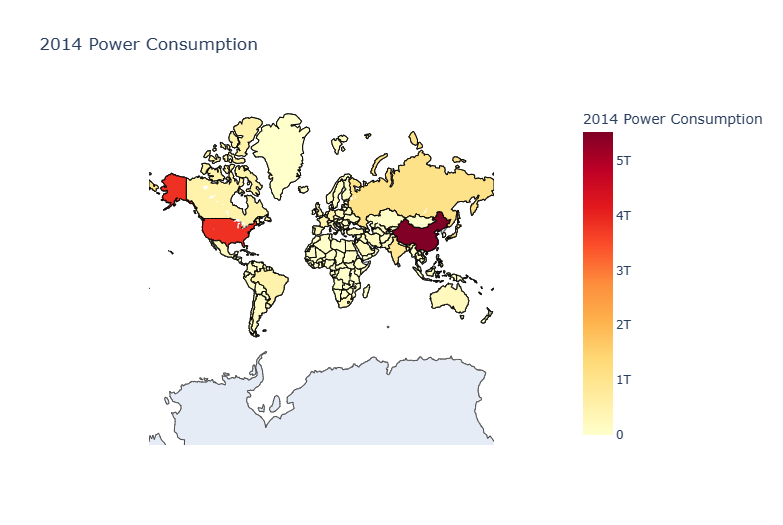
A 'globe' (orthographic) version (interactive) is produced below

In [59]:
layout = dict(title = '2014 Power Consumption',
             geo = dict(scope='world',showframe=True,
                        projection = {'type':"orthographic"}),
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

In [60]:
# Generating a larger size
choromap.update_layout(width=1000,height=800)
iplot(choromap,validate=False)

A static png version is given below
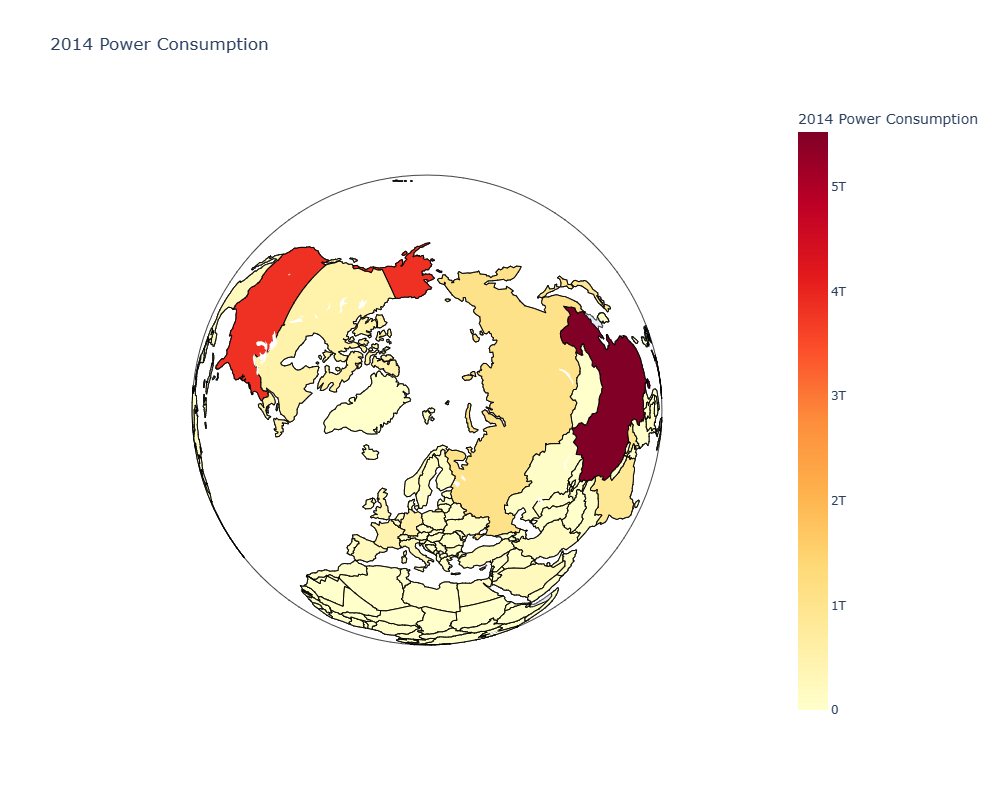
We note that the self-declared *Somaliland* has not been picked up by Plotly; it is not actually in the dataset

In [61]:
df[df['Country'].str.contains('Somaliland')==True]

,Country,Power Consumption KWH,Text,Text_split[0]


And *Somaliland* is not listed as a recognised country in *value_list*

In [62]:
'Somaliland' in value_list

False

This may change in future.

Back to the map and back to the 'mercator' view; this time with frames

In [63]:
layout = dict(title = '2014 Power Consumption',
             geo = dict(scope='world',showframe=True,
                        projection = {'type':"mercator"}),
             )
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

In [64]:
# Generating a larger size
choromap.update_layout(width=1000,height=800)
iplot(choromap,validate=False)

A static png image is below
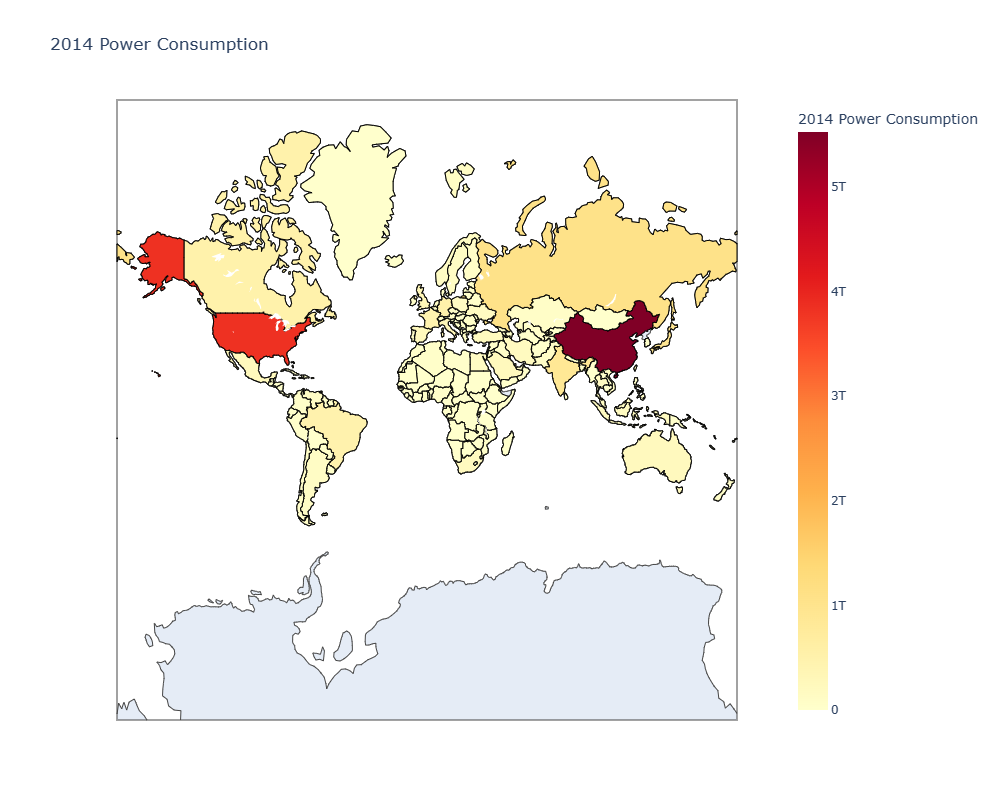
And finally, density maps; most of the hard work has already been done so this section will be relatively short, phew!

We still use Plotly for this, but a different subdirectory. We will also require a second library to help us with longitudes and latitudes—we need them for the type of map we will be generating. I should also point out that to be able to use some of the tool here, a token might be needed, depending on which *layers* are used
<br>
https://plotly.com/python/mapbox-layers/

In [65]:
import plotly.express as px
from geopy.geocoders import Nominatim

In [66]:
geolocator = Nominatim(user_agent='cu2')

Before running this, it is worth mentioning that *Geopy* is unable to find coordinates for *Palestinian Territory*, but it can if the territory is renamed *Gaza*, so I will do that now

In [67]:
df.loc[216,'Country'] = 'Gaza'
df.loc[216,'Text'] = 'Gaza 202,000'

In [68]:
df_geo = (
    df.assign(Geocodes= (df['Country']).apply(geolocator.geocode))
    .assign(Latitude = lambda x: [g.latitude for g in x['Geocodes']],
            Longitude= lambda x: [g.longitude for g in x['Geocodes']])
    .drop(columns='Geocodes')
)

In [69]:
df_geo.drop('Text_split[0]',axis=1,inplace=True)
df_geo.head()

,Country,Power Consumption KWH,Text,Latitude,Longitude
0,China,5.523000e+12,"China 5,523,000,000,000",35.000074,104.999927
1,United States,3.832000e+12,"United States 3,832,000,000,000",39.783730,-100.445882
2,European,2.771000e+12,"European 2,771,000,000,000",55.117352,61.614024
3,Russia,1.065000e+12,"Russia 1,065,000,000,000",64.686314,97.745306
4,Japan,9.210000e+11,"Japan 921,000,000,000",36.574844,139.239418


In [70]:
df_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                219 non-null    object 
 1   Power Consumption KWH  219 non-null    float64
 2   Text                   219 non-null    object 
 3   Latitude               219 non-null    float64
 4   Longitude              219 non-null    float64
dtypes: float64(3), object(2)
memory usage: 8.7+ KB


Now before generating this map, one thing to mention is that for some reason, *Nominatim* provides the wrong coordinates for the country *Georgia* by giving it the coordinates for *Georgia State* in the US!

In [71]:
df_geo[df_geo['Country'] == 'Georgia']

,Country,Power Consumption KWH,Text,Latitude,Longitude
94,Georgia,8.468000e+09,"Georgia 8,468,000,000",32.329381,-83.113737


I will therefore be correcting this manually

In [72]:
df_geo.loc[94,'Latitude'] = 41.716667
df_geo.loc[94,'Longitude'] = 44.783333

df_geo[df_geo['Country'] == 'Georgia']

,Country,Power Consumption KWH,Text,Latitude,Longitude
94,Georgia,8.468000e+09,"Georgia 8,468,000,000",41.716667,44.783333


In [73]:
df_geo

,Country,Power Consumption KWH,Text,Latitude,Longitude
0,China,5.523000e+12,"China 5,523,000,000,000",35.000074,104.999927
1,United States,3.832000e+12,"United States 3,832,000,000,000",39.783730,-100.445882
2,European,2.771000e+12,"European 2,771,000,000,000",55.117352,61.614024
3,Russia,1.065000e+12,"Russia 1,065,000,000,000",64.686314,97.745306
4,Japan,9.210000e+11,"Japan 921,000,000,000",36.574844,139.239418
...,...,...,...,...,...
214,Saint Pierre and Miquelon,7.440000e+06,"Saint Pierre and Miquelon 7,440,000",46.783247,-56.195159
215,Niue,2.790000e+06,"Niue 2,790,000",-19.053641,-169.861341
216,Gaza,2.020000e+05,"Gaza 202,000",-23.328398,32.806606
217,Malta,1.747000e+05,"Malta 174,700",35.888599,14.447691


In [74]:
density_map = px.density_mapbox(df_geo,
                                lat = 'Latitude',
                                lon = 'Longitude',
                                radius = 10,
                                zoom = 0.5,
                                width= 800,
                                height = 600,
                                hover_name = 'Text',
                                title = '2014 Power Consumption')

density_map.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
    ])
density_map.update_coloraxes(showscale=False)
density_map.show()

We notice that whilst power consumption is generally more intense in areas of high densities (indicating more people); this is not always the case; the *United States* and *China* are two good examples of this. Despite having sparse densities in various parts of their countries, energy usage is disproportionately high in those countries compared to other countries of the rest of the world.

A static png version is provided below
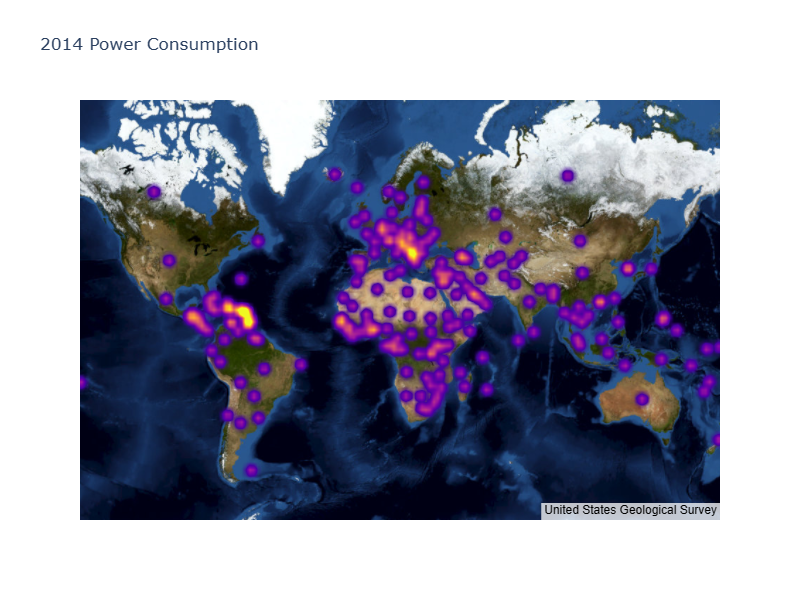